In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import datetime

from iminuit import Minuit
from iminuit.cost import LeastSquares
import iminuit
from scipy.optimize import curve_fit
import scipy.stats as stats

import strax
import straxen


In [2]:

st = straxen.contexts.xenonnt_online()


In [3]:

# exponential fit

def exp_fit(delta_times,tmax,nbins,t1,t2,p0=[1e5,58,10],title=''):
    
    
    # fitting function (exponential with constant background)

    def f(x,A,tau,c):        
        return A*np.exp(-x/tau) + c
    
    fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(8,5),sharex=True,gridspec_kw={'height_ratios': [4, 1]})
    plt.subplots_adjust(left=0.1,bottom=0, right=0.9, top=0.9, wspace=0, hspace=0)    
    
    # x and y
    
    y_,bin_borders,_ = ax[0].hist(delta_times,bins=nbins,range=(0,tmax),histtype='step',color='green',label='data')
    x_ = bin_borders[:-1] + np.diff(bin_borders) / 2 # bin centers

    
    # fit range
    x = x_[t1<x_]
    y = y_[t1<x_]
    s = x<t2
    y = y[s]
    x = x[s]

    
    # cost function
    
    least_squares = LeastSquares(x,y,np.sqrt(y),f)
    
    
    # fit
    
    m = Minuit(least_squares,A=p0[0],tau=p0[1],c=p0[2])
    m.limits['c'] = (0,None)
    # m.fixed['c'] = True
    m.migrad()
    m.hesse()
    
    
    # compute the p-value

    p_value = 1 - stats.chi2.cdf(m.fval,df=len(x)-m.nfit)
    
    
    # print the fit results
    
    print('Fit results:')
    print(f'A = '+str(m.values[0])+' +/- '+str(m.errors[0]))
    print(f'tau = '+str(m.values[1])+' +/- '+str(m.errors[1])+' ns')
    print(f'c = '+str(m.values[2])+' +/- '+str(m.errors[2]))
    print(f'chi2 / dof = '+str(m.fval)+' / '+str(len(x)-m.nfit))
    print(f'p-value = '+str(p_value))
    print('total number of entries: '+str(len(delta_times)))
    
    
    # plot and display the results
    
    xx = np.linspace(t1,t2,1000)
    yy = f(xx,m.values[0],m.values[1],m.values[2])
    ax[0].plot(xx,yy,color='red',label='fit')
    ax[0].set_title(title)
    ax[0].grid(alpha=0.3)
    plt.xlabel('time [ns]')
    ax[0].set_ylabel('counts')
    ax[0].set_yscale('log')
    
    fit_results = []
    fit_results.append(r'A = ( '+str(round(m.values[0]/1e3,2))+' $\pm$ '+str(round(m.errors[0]/1e3,2))+' ) $\cdot 10^3$')
    fit_results.append(r'$\tau$ = '+str(round(m.values[1],2))+' $\pm$ '+str(round(m.errors[1],2))+' ns')
    fit_results.append(r'c = '+str(round(m.values[2],2))+' $\pm$ '+str(round(m.errors[2],2)))
    fit_results.append(r'$\chi^2$ / dof = '+str(round(m.fval,1))+' / '+str(len(x)-m.nfit))
    fit_results.append(f'p-value = {p_value:.2f}')
    ax[0].legend(title='\n'.join(fit_results),loc='upper right')
                           
    
    # plot the residuals
    
    y_fit = f(x,m.values[0],m.values[1],m.values[2])
    res = (y - y_fit) / np.sqrt(y)
    # plt.figure(figsize=(6.1,1.5))
    ax[1].scatter(x,res,s=3,c="black")
    ax[1].set_ylabel("pull")
    ax[1].axhline(0,linestyle="--",color="red",alpha=0.7)
    ax[1].axhline(-1,linestyle="--",color="green",alpha=0.5)
    ax[1].axhline(1,linestyle="--",color="green",alpha=0.5)
    ax[1].axhline(-2,linestyle="--",color="orange",alpha=0.5)
    ax[1].axhline(2,linestyle="--",color="orange",alpha=0.5)
    ax[1].axhline(-3,linestyle="--",color="blue",alpha=0.5)
    ax[1].axhline(3,linestyle="--",color="blue",alpha=0.5)
    plt.show()
                
    
    # reduced chi2
                           
    rcs = m.fval / (len(x)-m.nfit)
           
                           
    # return tau, tau error, reduced chi2, noise rate, noise rate error
    
    return m.values[1],m.errors[1],rcs,p_value
                 

In [8]:

# define the runs on which apply the algorithm to find the
# hitlet timings

starting_date = datetime.date(2022,4,8)
ending_date = datetime.date(2022,9,15)
day_step = 7

dates_of_the_runs = [starting_date]
today = starting_date
while today < ending_date:
    today += datetime.timedelta(days=7)
    dates_of_the_runs.append(today)

dates_of_the_runs = np.array(dates_of_the_runs)


In [9]:

# define the runs to be analysed


# get all the runs available
df = st.select_runs(run_mode=('background_linked','nVeto_self_trigger'),available='events_nv',exclude_tags=('abandon','messy'))

# get the runs
runs = []
for date in dates_of_the_runs:
    run_id = df.loc[df['start'].array.date==date].iloc[0]['name']
    runs.append([run_id,date])

runs = np.array(runs)


In [10]:
runs

array([['041901', datetime.date(2022, 4, 8)],
       ['042110', datetime.date(2022, 4, 15)],
       ['042299', datetime.date(2022, 4, 22)],
       ['042504', datetime.date(2022, 4, 29)],
       ['042708', datetime.date(2022, 5, 6)],
       ['042892', datetime.date(2022, 5, 13)],
       ['043090', datetime.date(2022, 5, 20)],
       ['043514', datetime.date(2022, 5, 27)],
       ['043834', datetime.date(2022, 6, 3)],
       ['044171', datetime.date(2022, 6, 10)],
       ['044657', datetime.date(2022, 6, 17)],
       ['045076', datetime.date(2022, 6, 24)],
       ['045394', datetime.date(2022, 7, 1)],
       ['045727', datetime.date(2022, 7, 8)],
       ['045977', datetime.date(2022, 7, 15)],
       ['046270', datetime.date(2022, 7, 22)],
       ['046481', datetime.date(2022, 7, 29)],
       ['046696', datetime.date(2022, 8, 5)],
       ['046868', datetime.date(2022, 8, 12)],
       ['047038', datetime.date(2022, 8, 19)],
       ['047262', datetime.date(2022, 8, 26)],
       ['047347', d

In [12]:
for run in runs:
    print(st.is_stored(run[0],'hitlets_nv'))

False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [12]:

# find the names of the files
filenames = np.array([ run[0]+'_'+str(run[1].year)+'_'+str(run[1].month)+'_'+str(run[1].day) for run in runs])


In [13]:
filenames

array(['041901_2022_4_8', '042110_2022_4_15', '042299_2022_4_22',
       '042504_2022_4_29', '042708_2022_5_6', '042892_2022_5_13',
       '043090_2022_5_20', '043514_2022_5_27', '043834_2022_6_3',
       '044171_2022_6_10', '044657_2022_6_17', '045076_2022_6_24',
       '045394_2022_7_1', '045727_2022_7_8', '045977_2022_7_15',
       '046270_2022_7_22', '046481_2022_7_29', '046696_2022_8_5',
       '046868_2022_8_12', '047038_2022_8_19', '047262_2022_8_26',
       '047347_2022_9_2', '047453_2022_9_9', '047548_2022_9_16'],
      dtype='<U16')

Fit results:
A = 5629.829354780641 +/- 100.78924388041881
tau = 59.0506445343055 +/- 1.1071506194470857 ns
c = 9.885405994978498 +/- 10.731206044549099
chi2 / dof = 84.56467735641041 / 72
p-value = 0.1476623463218636
total number of entries: 148460


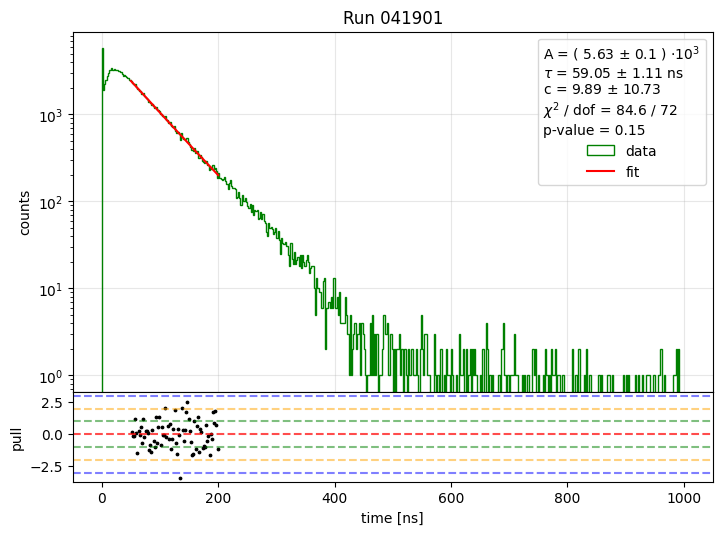

Fit results:
A = 6013.847426396442 +/- 107.45108039590727
tau = 56.887905773929155 +/- 1.0021635044047676 ns
c = 23.43173366889605 +/- 11.931650885720526
chi2 / dof = 96.09353438883394 / 72
p-value = 0.03049191927653716
total number of entries: 155239


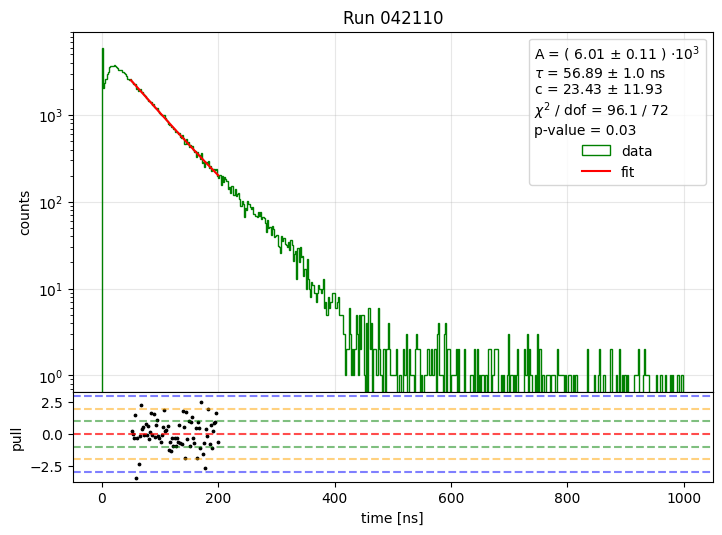

Fit results:
A = 6188.91283534424 +/- 110.08230317326247
tau = 56.894258384646555 +/- 0.9999174093055883 ns
c = 32.63524267816278 +/- 12.272180023941262
chi2 / dof = 93.26569804662512 / 72
p-value = 0.04676946032611495
total number of entries: 155262


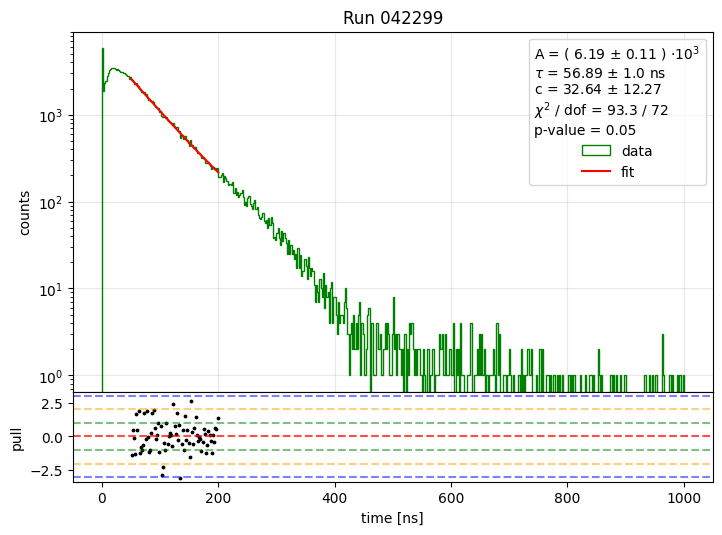

Fit results:
A = 5638.33895377882 +/- 98.3714874101638
tau = 60.11278454822847 +/- 1.1307838963450323 ns
c = 1.966307288369147 +/- 11.192879445900855
chi2 / dof = 63.07781746092645 / 72
p-value = 0.7643824993274541
total number of entries: 154838


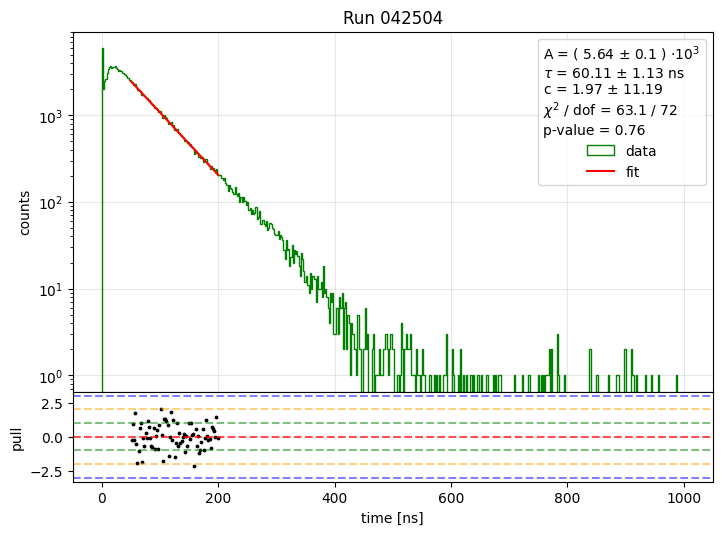

Fit results:
A = 5851.633367701353 +/- 106.02075867233036
tau = 57.77166390266314 +/- 1.0625590143226076 ns
c = 38.16692241602773 +/- 12.567348412826695
chi2 / dof = 73.61770291619553 / 72
p-value = 0.42492837386219195
total number of entries: 154809


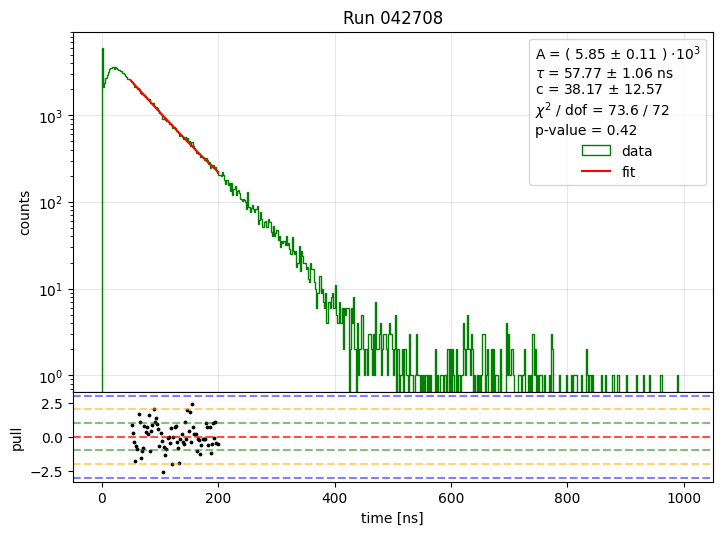

Fit results:
A = 5847.869795997604 +/- 105.21832282244739
tau = 58.05849414593593 +/- 1.0656926491999976 ns
c = 25.11483754551626 +/- 12.585094357860376
chi2 / dof = 47.3141218786368 / 72
p-value = 0.9891952744948006
total number of entries: 155931


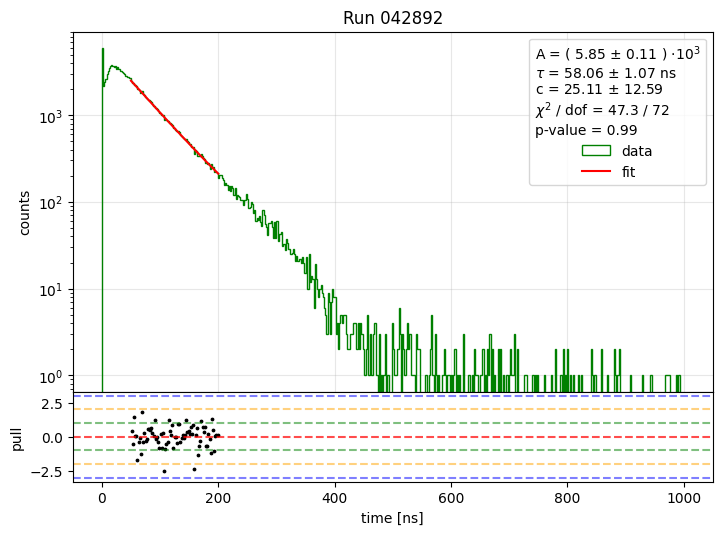

Fit results:
A = 5688.538267123085 +/- 103.70681080381314
tau = 58.4889663528053 +/- 1.1027247730226073 ns
c = 26.72293056908425 +/- 12.769810394624884
chi2 / dof = 87.93453971131675 / 72
p-value = 0.09756828378998916
total number of entries: 154901


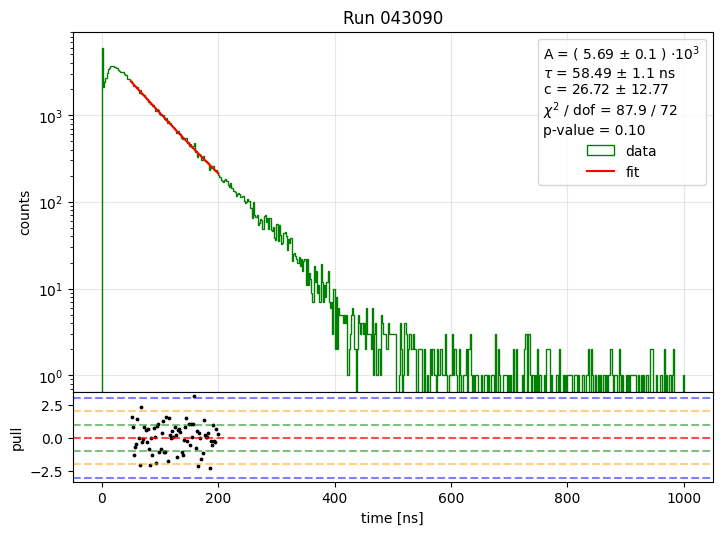

Fit results:
A = 5753.127329520431 +/- 107.44606654641301
tau = 57.274274993481136 +/- 1.0735923046580775 ns
c = 49.32510369456463 +/- 12.396269847222776
chi2 / dof = 86.10506515715868 / 72
p-value = 0.12279355886805143
total number of entries: 154681


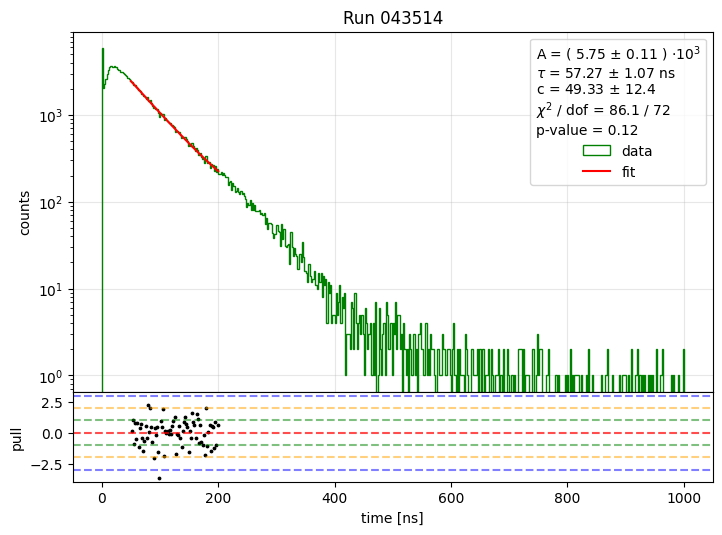

Fit results:
A = 5847.697125545639 +/- 107.07981825722639
tau = 57.1922320204021 +/- 1.048074511063681 ns
c = 46.53759398815863 +/- 12.309971558182262
chi2 / dof = 65.24301845682032 / 72
p-value = 0.7004481485975327
total number of entries: 155486


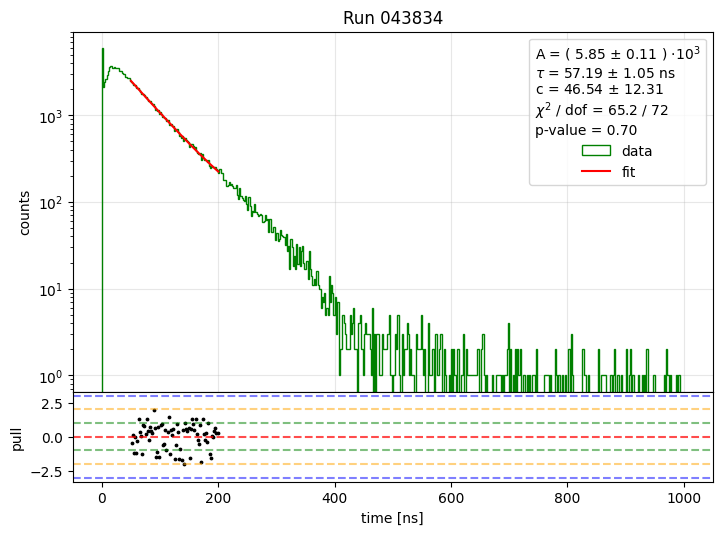

Fit results:
A = 5963.621218025125 +/- 109.62517033485624
tau = 56.329281757331756 +/- 1.0126493581351412 ns
c = 51.38723376044548 +/- 11.969896690139961
chi2 / dof = 72.05363581135379 / 72
p-value = 0.47605499087305125
total number of entries: 156472


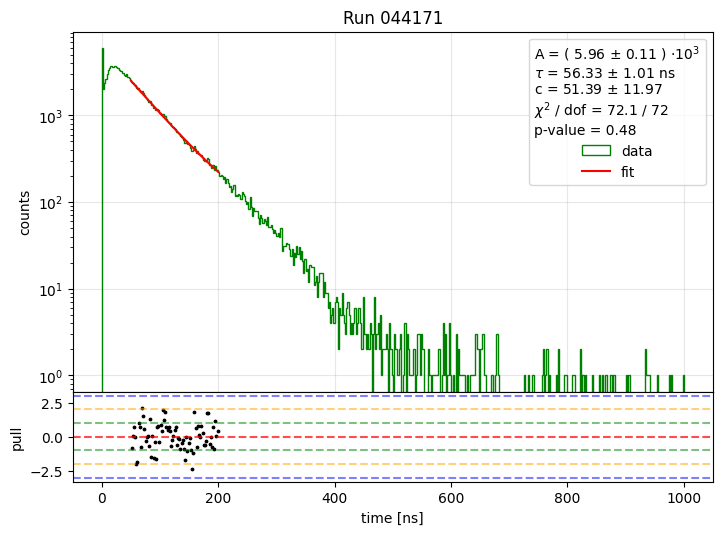

Fit results:
A = 6072.784349642582 +/- 109.74018426340676
tau = 57.13852463664473 +/- 1.0279647057180081 ns
c = 36.53884653365517 +/- 12.42122376669482
chi2 / dof = 65.00188462912773 / 72
p-value = 0.7078672910090215
total number of entries: 156185


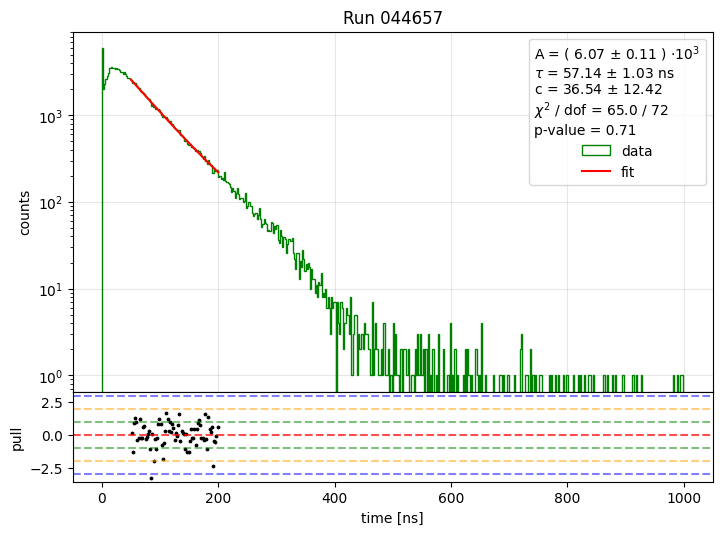

Fit results:
A = 5830.140856162717 +/- 107.9606042197139
tau = 56.88616611278866 +/- 1.0477261310275758 ns
c = 54.67568971358372 +/- 12.242884348886868
chi2 / dof = 84.31059107812038 / 72
p-value = 0.15209878216087802
total number of entries: 155646


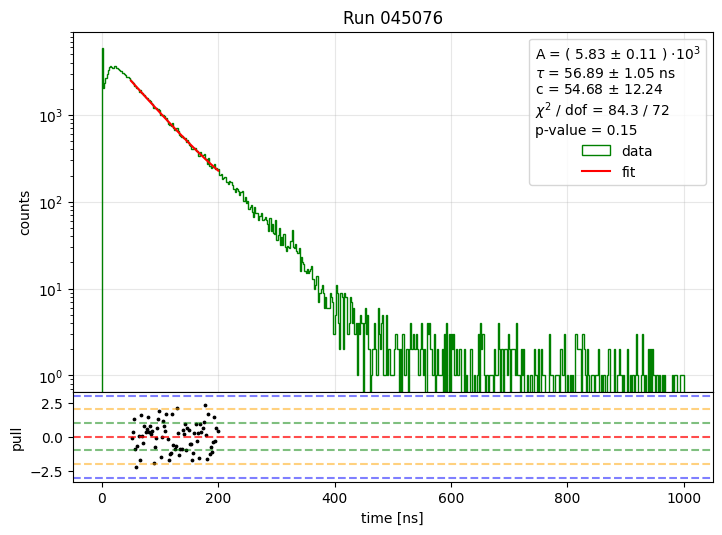

Fit results:
A = 5925.195001478644 +/- 105.94106822950323
tau = 57.840380850808614 +/- 1.0419394628455656 ns
c = 11.639381715529504 +/- 11.96282709468748
chi2 / dof = 75.93245496551845 / 72
p-value = 0.35298800314786016
total number of entries: 155566


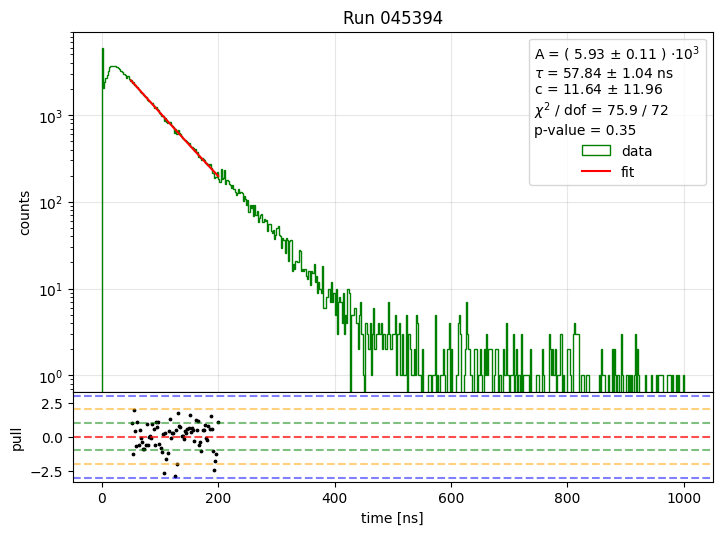

Fit results:
A = 5938.355554792533 +/- 107.93711305124538
tau = 57.35237249947429 +/- 1.045222008865542 ns
c = 38.92545043144891 +/- 12.430532709310258
chi2 / dof = 91.46999089022312 / 72
p-value = 0.06055246985255014
total number of entries: 156117


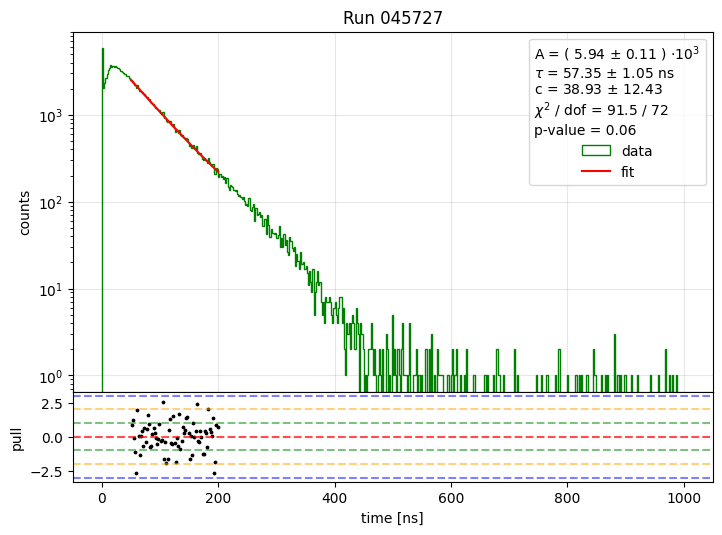

Fit results:
A = 5875.289768705945 +/- 107.52433926168429
tau = 57.458705330674995 +/- 1.0580470273506504 ns
c = 38.956430675947736 +/- 12.470342656544966
chi2 / dof = 65.68898573829708 / 72
p-value = 0.6865563844345293
total number of entries: 155915


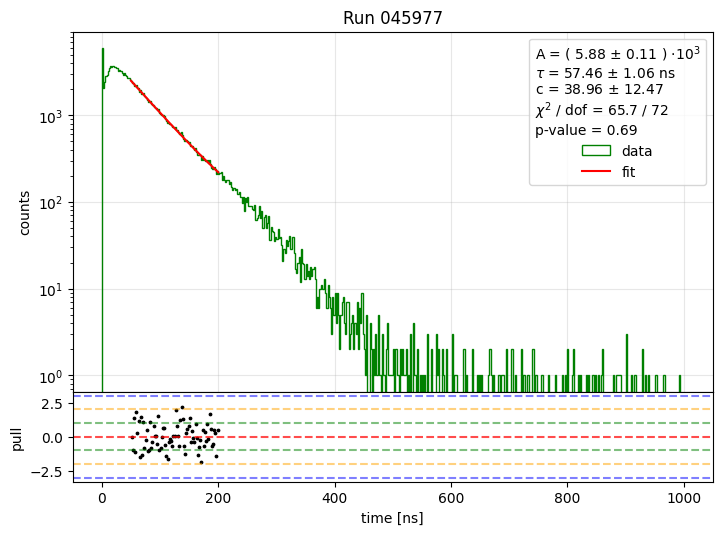

Fit results:
A = 5766.768028499368 +/- 103.99858572709348
tau = 58.32345101143984 +/- 1.082655156221547 ns
c = 25.834948223664806 +/- 12.692719239224779
chi2 / dof = 49.280443847454634 / 72
p-value = 0.9813521846124201
total number of entries: 155196


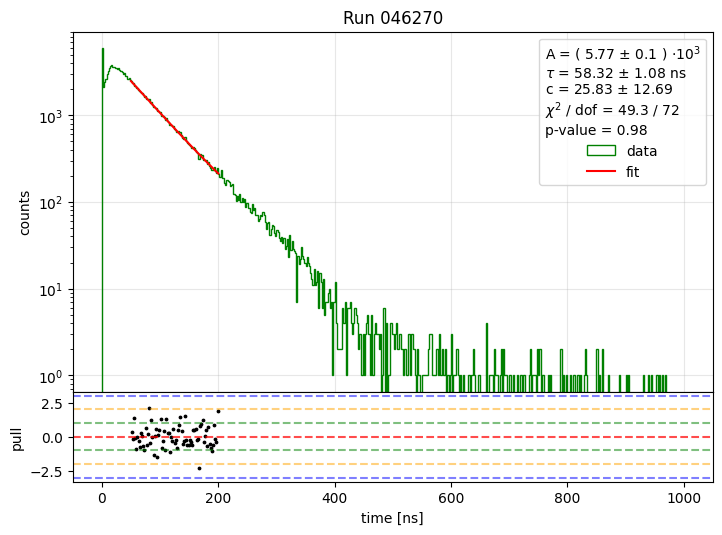

Fit results:
A = 5913.087027594123 +/- 109.00145801556054
tau = 56.717242541638676 +/- 1.0318475889260539 ns
c = 44.81675855083925 +/- 12.118559938738422
chi2 / dof = 71.0952560304996 / 72
p-value = 0.5080034543566285
total number of entries: 155646


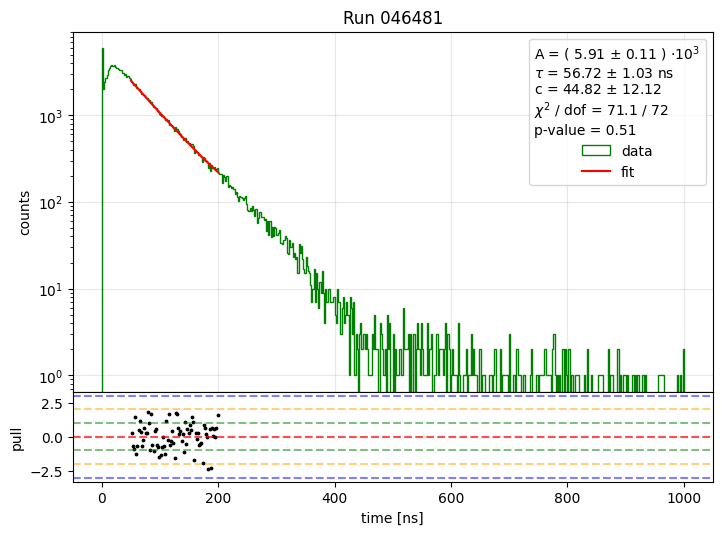

Fit results:
A = 5691.26762287224 +/- 103.25543596234324
tau = 58.571287320673584 +/- 1.105213082578688 ns
c = 39.53179892616901 +/- 12.921298962454792
chi2 / dof = 80.88704565119795 / 72
p-value = 0.22148679838320295
total number of entries: 155890


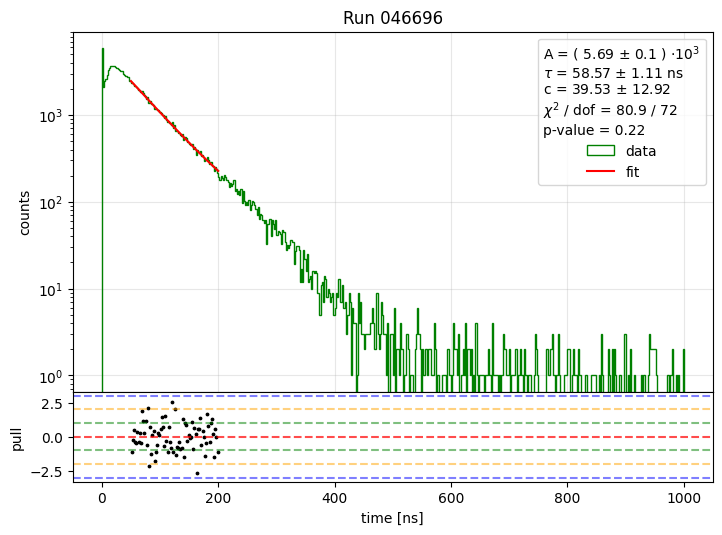

Fit results:
A = 5923.328015929991 +/- 108.56139091633094
tau = 56.75572987787201 +/- 1.0265106074206796 ns
c = 38.66147161879402 +/- 12.066246755573173
chi2 / dof = 81.97244690074062 / 72
p-value = 0.197529745395304
total number of entries: 155426


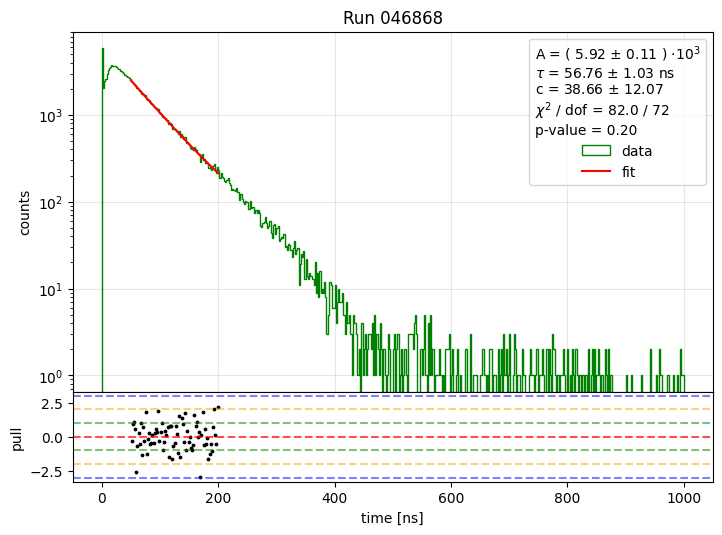

Fit results:
A = 6015.001728845757 +/- 106.27977000307641
tau = 58.186130222168444 +/- 1.0564228697630274 ns
c = 36.896041317816646 +/- 12.95505256280203
chi2 / dof = 77.84825029314713 / 72
p-value = 0.2980638184222596
total number of entries: 155928


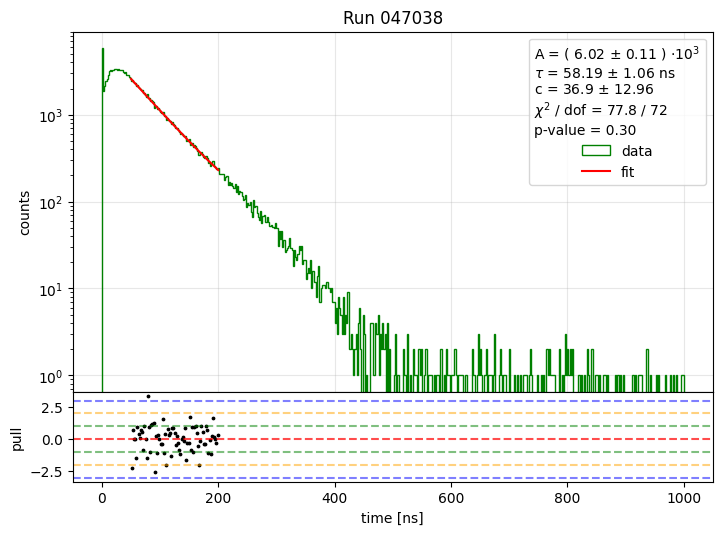

Fit results:
A = 6322.437504001333 +/- 115.51062219351805
tau = 55.69876349487248 +/- 0.9774562813771146 ns
c = 62.130407561522176 +/- 12.075860623573003
chi2 / dof = 72.45161093388548 / 72
p-value = 0.4629044442506879
total number of entries: 156878


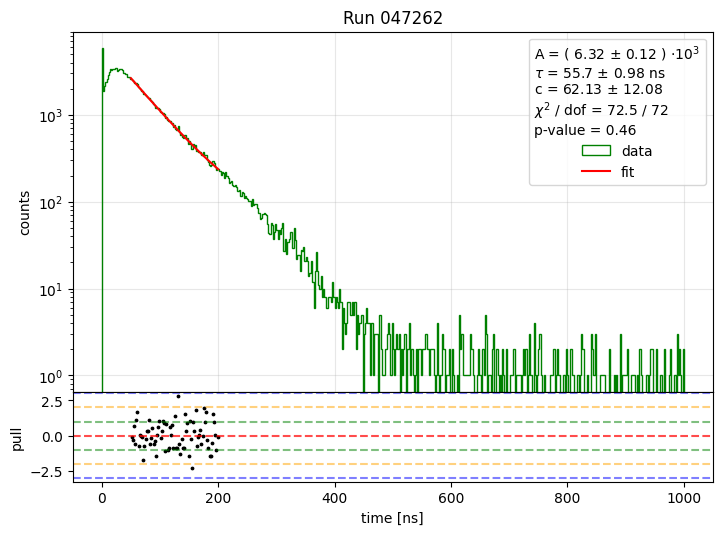

Fit results:
A = 5919.578237967633 +/- 106.84480901444947
tau = 57.31015946272407 +/- 1.0371691334706292 ns
c = 35.40352905746081 +/- 12.3258930819677
chi2 / dof = 91.56363319180296 / 72
p-value = 0.05975801578375606
total number of entries: 156174


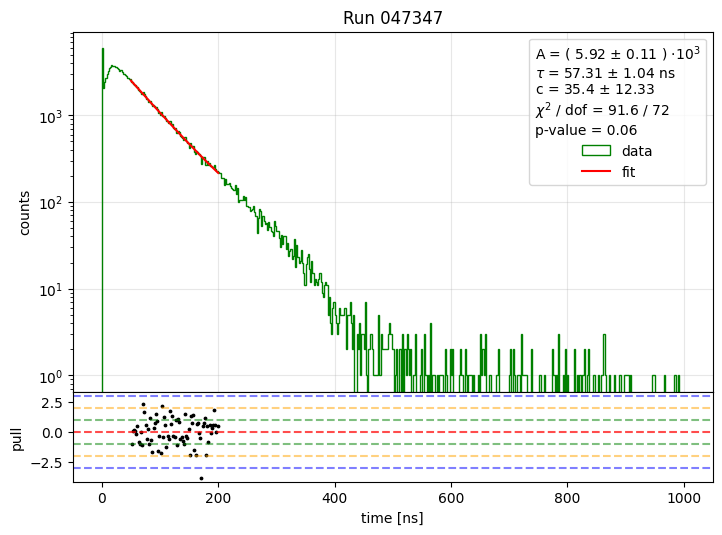

Fit results:
A = 6068.783830530903 +/- 111.34589757616625
tau = 55.985709888643015 +/- 0.9909151855311613 ns
c = 45.51625672727987 +/- 11.762739147090347
chi2 / dof = 74.68589267111206 / 72
p-value = 0.3910734890730021
total number of entries: 156730


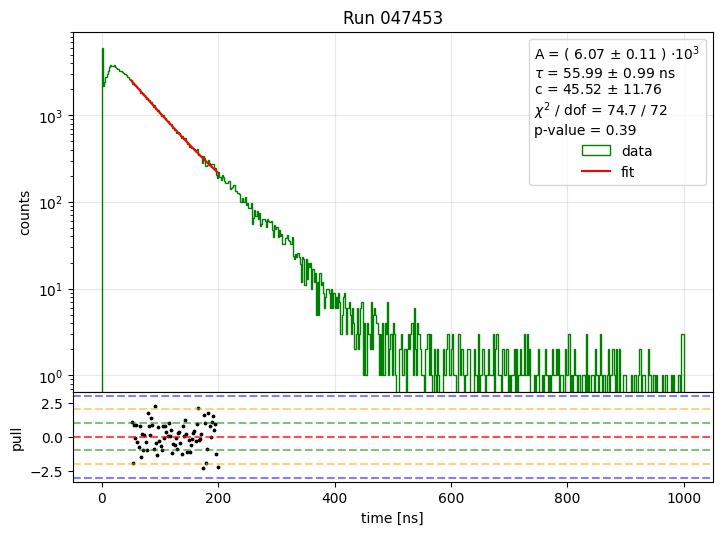

Fit results:
A = 6081.9075959103675 +/- 107.62665656351083
tau = 57.63311169028457 +/- 1.028698697900527 ns
c = 25.84525929427348 +/- 12.559473153536604
chi2 / dof = 66.14980163697929 / 72
p-value = 0.6719871955216894
total number of entries: 155997


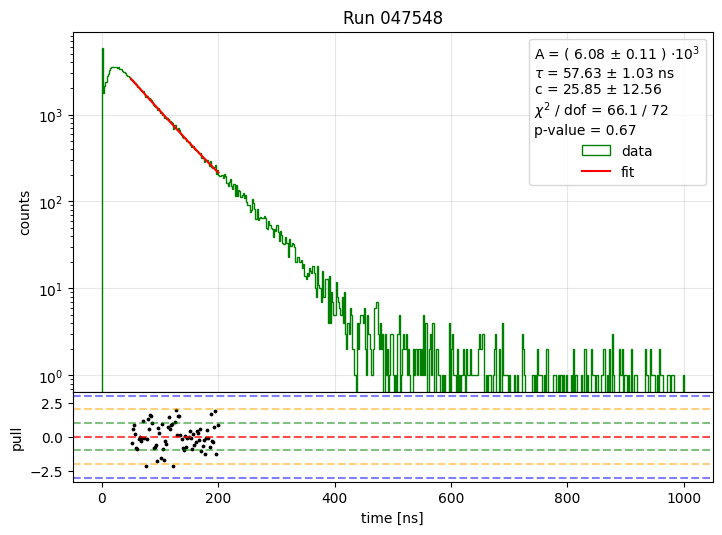

In [14]:

# make the fits

cut_on_npmts = 20
cut_on_max_npmts = 40
cut_on_hitlets_area = 0

min_t = 50
max_t = 200

taus = []
tau_errs = []
p_values = []

for filename in filenames:
    
    timings = np.load('timings_data_'+str(cut_on_npmts)+'_'+str(cut_on_max_npmts)+'_'+str(cut_on_hitlets_area)+'/'+filename+'.npy')
    # timings = np.load('timings_data_'+str(cut_on_npmts)+'_'+str(cut_on_hitlets_area)+'/'+filename+'.npy')
    
    '''
    plt.hist(timings,range=(0,800),bins=400,color='green',histtype='step')
    plt.xlabel('time [ns]')
    plt.ylabel('counts')
    plt.grid(alpha=0.5)
    plt.title('Run '+filename[:6]+' - n_pmts > '+str(cut_on_npmts))
    plt.yscale('log')
    plt.show()
    '''
    
    tau, tau_err, _, p_value = exp_fit(timings,tmax=1000,nbins=500,t1=min_t,t2=max_t,p0=[1e5,58,1],title='Run '+filename[:6])
    
    taus.append(tau)
    tau_errs.append(tau_err)
    p_values.append(p_value)


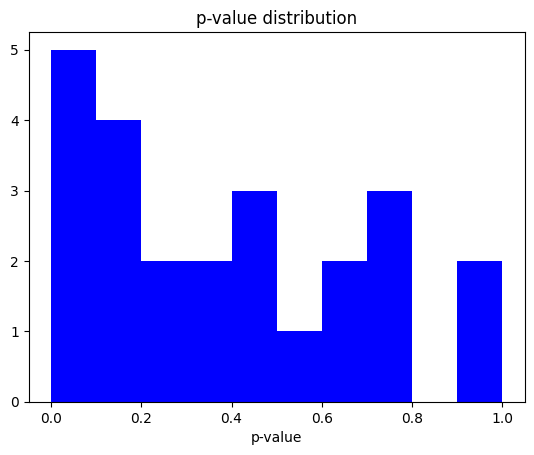

In [15]:

# plot the p-value distribution
plt.hist(p_values,range=(0,1),bins=10,color='blue')
plt.title('p-value distribution')
plt.xlabel('p-value')
plt.show()


In [11]:
np.sort(p_values)

array([0.03049192, 0.04676946, 0.05975802, 0.06055247, 0.09756828,
       0.12279356, 0.14766235, 0.15209878, 0.19752975, 0.2214868 ,
       0.29806382, 0.352988  , 0.39107349, 0.42492837, 0.46290444,
       0.47605499, 0.50800345, 0.6719872 , 0.68655638, 0.70044815,
       0.70786729, 0.7643825 , 0.98135218, 0.98919527])

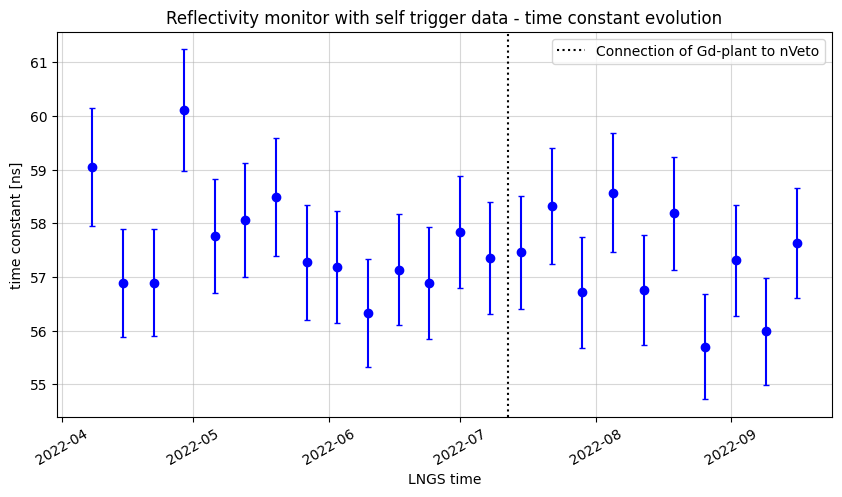

In [12]:

# plot the time constant evolution

plt.figure(figsize=(10,5))

plt.errorbar(runs[:,1],taus,yerr=tau_errs,fmt='o',color='blue',capsize=2)
       
plt.title('Reflectivity monitor with self trigger data - time constant evolution')
plt.xlabel('LNGS time')
plt.ylabel('time constant [ns]')
# plt.ylim(53,64)
plt.grid(alpha=0.5)
ax = plt.gca()
plt.xticks(rotation = 30)
plt.gca().axvline(datetime.date(2022,7,12),linestyle=':',color='black',label='Connection of Gd-plant to nVeto')
plt.legend()
plt.show()


In [4]:

av_means = np.load('average_backup_thesis.npy',allow_pickle=True)


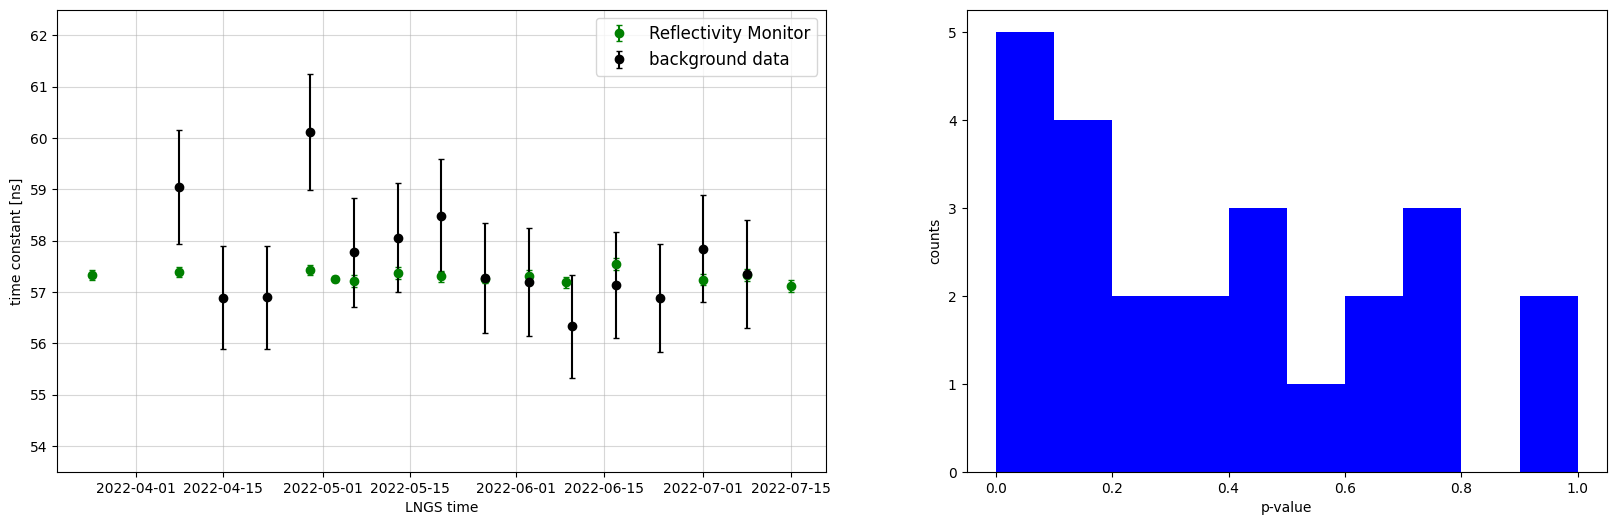

In [16]:

fig, ax = plt.subplots(1,2,figsize=(20,6),gridspec_kw={'width_ratios': [1.2,1]})

ax[0].set_xlabel('LNGS time')
ax[0].set_ylabel('time constant [ns]')
ax[0].grid(alpha=0.5)
ax[0].errorbar(av_means[4:18,0],av_means[4:18,1],yerr=av_means[4:18,2],fmt='o',capsize=2,color='green',label='Reflectivity Monitor')
ax[0].errorbar(runs[:14,1],taus[:14],yerr=tau_errs[:14],fmt='o',color='black',capsize=2,label='background data')
ax[0].set_ylim(53.5,62.5)
ax[0].legend(fontsize=12)

# ax[0].axhline(np.mean(av_means[4:28,1]),color='green',linestyle=':')
# ax[0].axhline(np.mean(taus),color='black',linestyle=':')


ax[1].set_xlabel('p-value')
ax[1].set_ylabel('counts')
ax[1].hist(p_values,range=(0,1),bins=10,color='blue')


fig.savefig('../../plots_chapter3/ref_mon_compare.jpg',dpi=400,bbox_inches='tight')


plt.show()


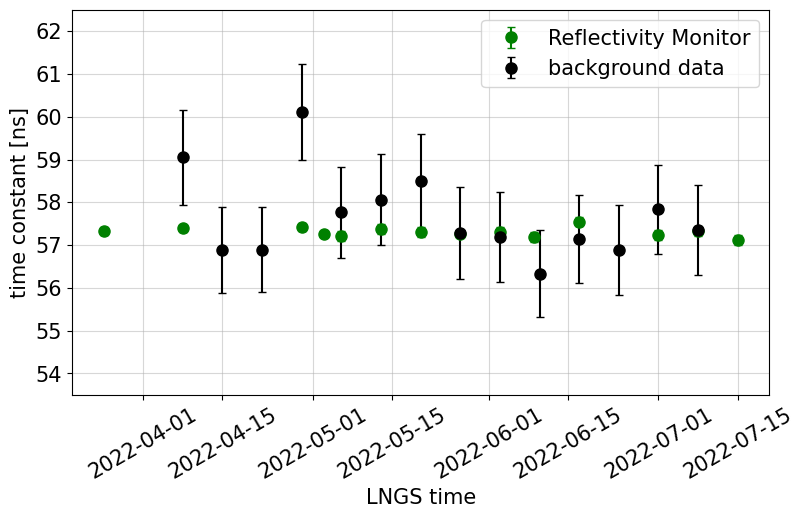

In [21]:

fig = plt.figure(figsize=(9,5))

plt.xlabel('LNGS time',fontsize=15)
plt.ylabel('time constant [ns]',fontsize=15)
plt.grid(alpha=0.5)
plt.errorbar(av_means[4:18,0],av_means[4:18,1],yerr=av_means[4:18,2],fmt='o',capsize=3,color='green',label='Reflectivity Monitor',
             markersize='8')
plt.errorbar(runs[:14,1],taus[:14],yerr=tau_errs[:14],fmt='o',color='black',capsize=3,label='background data',markersize='8')
plt.ylim(53.5,62.5)
plt.legend(fontsize=15)
plt.xticks(fontsize=15,rotation=30)
plt.yticks(fontsize=15)

fig.savefig('../../plots_chapter3/ref_mon_compare_2.jpg',dpi=400,bbox_inches='tight')

plt.show()


In [41]:
print(np.mean(av_means[4:17,1]),np.mean(taus[:14]))

57.32207818786873 57.66271075147292


In [32]:

taus_ref_mon = np.load('../backup_ref_mon/taus.npy',allow_pickle=True)
tau_errs_ref_mon = np.load('../backup_ref_mon/tau_errs.npy',allow_pickle=True)
good_runs = np.load('../backup_ref_mon/good_runs.npy',allow_pickle=True)
# runs = np.load('../backup_ref_mon/runs.npy',allow_pickle=True)


In [33]:
taus_ref_mon[0]

array([56.71243079, 55.96100852, 56.85150595, 55.60785542, 55.79593664,
       55.36634343, 55.91728609, 55.9943573 , 55.41138377, 55.90604218,
       56.05820329, 56.03302368, 56.40261791, 56.05532371, 56.34008306,
       55.87562738, 56.92773769, 55.96916578, 56.00138189, 54.92435833,
       55.9911199 , 55.87084386, 55.36064399, 55.30413453, 55.7606618 ,
       55.68337123, 55.0516545 , 55.35826028, 55.5999445 , 55.09511529,
       55.70204911, 54.98725453, 56.31616927, 55.36057551, 56.10338427,
       55.87936976, 55.44890261, 55.52521628, 56.0993258 , 55.06588531])

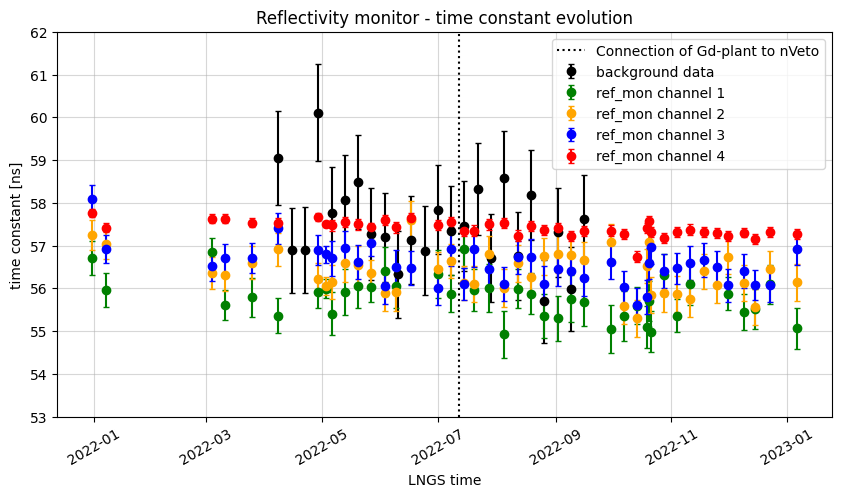

In [46]:

# plot the time constant evolution together with the ones coming
# from the reflectivity monitor runs

plt.figure(figsize=(10,5))

colors = ['green','orange','blue','red']

plt.errorbar(runs[:,1],taus,yerr=tau_errs,fmt='o',color='black',capsize=2,label='background data')
plt.errorbar([good_runs[0][i][0] for i in range(len(good_runs[0]))],taus_ref_mon[0],yerr=tau_errs_ref_mon[0],fmt='o',color=colors[0],capsize=2,label='ref_mon channel 1')
plt.errorbar([good_runs[1][i][0] for i in range(len(good_runs[1]))],taus_ref_mon[1],yerr=tau_errs_ref_mon[1],fmt='o',color=colors[1],capsize=2,label='ref_mon channel 2')
plt.errorbar([good_runs[2][i][0] for i in range(len(good_runs[2]))],taus_ref_mon[2],yerr=tau_errs_ref_mon[2],fmt='o',color=colors[2],capsize=2,label='ref_mon channel 3')
plt.errorbar([good_runs[3][i][0] for i in range(len(good_runs[3]))],taus_ref_mon[3],yerr=tau_errs_ref_mon[3],fmt='o',color=colors[3],capsize=2,label='ref_mon channel 4')

       
plt.title('Reflectivity monitor - time constant evolution')
plt.xlabel('LNGS time')
plt.ylabel('time constant [ns]')
plt.ylim(53,62)
plt.grid(alpha=0.5)
plt.gca().axvline(datetime.date(2022,7,12),linestyle=':',color='black',label='Connection of Gd-plant to nVeto')
plt.legend()
plt.xticks(rotation = 30)
plt.show()


In [52]:
for i in range(len(taus_ref_mon)):
    print(len(taus_ref_mon[i]))

40
43
43
43


In [53]:

av_means = []
av_mean_errs = []

for i in range(len(good_runs[0])):
    
    tau_channels = np.array([ taus_ref_mon[j][i] for j in range(len(taus_ref_mon)) if taus_ref_mon[j][i] != -1 ])
    tau_errs_channels = np.array([ tau_errs_ref_mon[j][i] for j in range(len(tau_errs_ref_mon)) if tau_errs_ref_mon[j][i] != -1 ])
    
    av_mean = np.sum( tau_channels / ( tau_errs_channels * tau_errs_channels ) ) / np.sum( np.repeat(1,len(tau_errs_channels)) / ( tau_errs_channels * tau_errs_channels ) )
    av_mean_err = np.sqrt( 1 / np.sum( np.repeat(1,len(tau_errs_channels)) / ( tau_errs_channels * tau_errs_channels ) ) )
    
    av_means.append(av_mean)
    av_mean_errs.append(av_mean_err)
    

In [48]:
len([good_runs[3][i][0] for i in range(len(good_runs[3]))])

43

In [49]:
len(av_means)

40

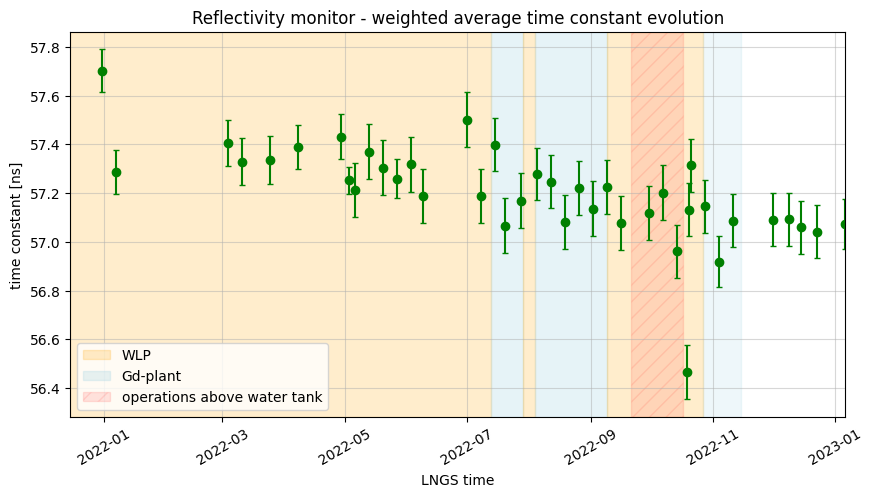

In [54]:

# plot the time constant evolution made from the weighted average of
# the taus of the ref_mon runs

plt.figure(figsize=(10,5))

plt.errorbar([good_runs[0][i][0] for i in range(len(good_runs[0]))],av_means,yerr=av_mean_errs,fmt='o',color='green',capsize=2)
       
plt.title('Reflectivity monitor - weighted average time constant evolution')
plt.xlabel('LNGS time')
plt.ylabel('time constant [ns]')
plt.grid(alpha=0.5)
# plt.gca().axvline(datetime.date(2022,7,12),linestyle=':',color='black',label='Connection of Gd-plant to nVeto')
plt.gca().axvspan(datetime.date(2021,12,15),datetime.date(2022,7,13),color='orange',alpha=0.2,label='WLP',zorder=1)
plt.gca().axvspan(datetime.date(2022,7,13),datetime.date(2022,7,29),color='lightblue',alpha=0.3,label='Gd-plant')
plt.gca().axvspan(datetime.date(2022,7,29),datetime.date(2022,8,4),color='orange',alpha=0.2)
plt.gca().axvspan(datetime.date(2022,8,4),datetime.date(2022,9,9),color='lightblue',alpha=0.3)
plt.gca().axvspan(datetime.date(2022,9,9),datetime.date(2022,10,27),color='orange',alpha=0.2)
plt.gca().axvspan(datetime.date(2022,10,27),datetime.date(2022,11,15),color='lightblue',alpha=0.2)
plt.gca().axvspan(datetime.date(2022,9,21),datetime.date(2022,10,17),color='red',alpha=0.1,label='operations above water tank',hatch='//')
plt.gca().margins(x=0)


plt.legend()
plt.xticks(rotation = 30)
plt.show()


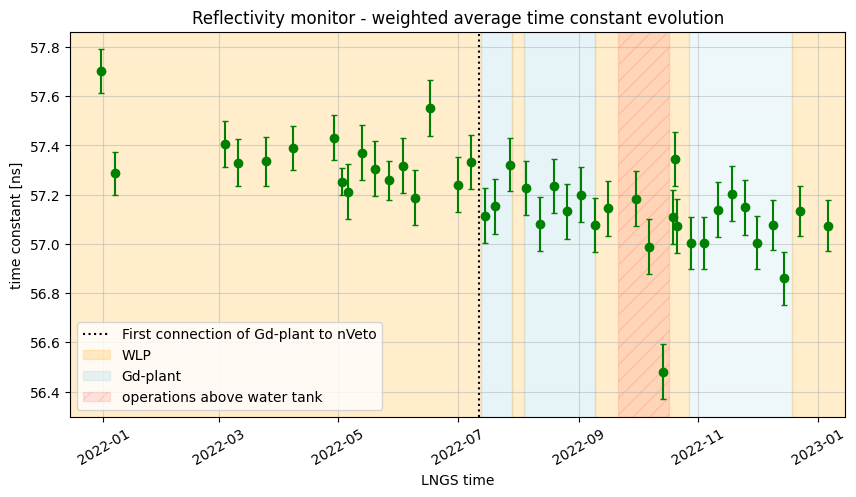

In [5]:

# compute the weigthed averages and plot them

run_dates = np.array([ run[0] for run in runs[0] ])
good_runs_dates = np.array([ np.array([ runs[channel-1][i][0] for i in range(len(runs[channel-1])) if runs[channel-1][i][0] in [good_runs[channel-1][j][0] for j in range(len(good_runs[channel-1]))] ]) for channel in [1,2,3,4] ],dtype=object)

weighted_averages = []
w_av_errors = []
used_runs = []

for date in run_dates:
    
    taus_date = np.array([ taus_ref_mon[channel-1][int(np.where(good_runs_dates[channel-1]==date)[0])] for channel in [1,2,3,4] if date in good_runs_dates[channel-1] ])
    tau_errs_date = np.array([ tau_errs_ref_mon[channel-1][int(np.where(good_runs_dates[channel-1]==date)[0])] for channel in [1,2,3,4] if date in good_runs_dates[channel-1] ])
            
    if len(taus_date) > 0:
        
        weighted_average = np.sum(taus_date/(tau_errs_date**2)) / np.sum(1/(tau_errs_date**2))
        w_av_error = np.sqrt( 1 / np.sum(1/(tau_errs_date**2)) )
        weighted_averages.append(weighted_average)
        w_av_errors.append(w_av_error)
        used_runs.append(date)
    
    
plt.figure(figsize=(10,5))

plt.errorbar(used_runs,weighted_averages,yerr=w_av_errors,fmt='o',color='green',capsize=2)
       
plt.title('Reflectivity monitor - weighted average time constant evolution')
plt.xlabel('LNGS time')
plt.ylabel('time constant [ns]')
plt.grid(alpha=0.5)
plt.gca().axvline(datetime.date(2022,7,12),linestyle=':',color='black',label='First connection of Gd-plant to nVeto')
plt.xticks(rotation = 30)

plt.gca().axvspan(datetime.date(2021,12,15),datetime.date(2022,7,13),color='orange',alpha=0.2,label='WLP',zorder=1)
plt.gca().axvspan(datetime.date(2022,7,13),datetime.date(2022,7,29),color='lightblue',alpha=0.3,label='Gd-plant')
plt.gca().axvspan(datetime.date(2022,7,29),datetime.date(2022,8,4),color='orange',alpha=0.2)
plt.gca().axvspan(datetime.date(2022,8,4),datetime.date(2022,9,9),color='lightblue',alpha=0.3)
plt.gca().axvspan(datetime.date(2022,9,9),datetime.date(2022,10,27),color='orange',alpha=0.2)
plt.gca().axvspan(datetime.date(2022,10,27),datetime.date(2022,12,19),color='lightblue',alpha=0.2)
plt.gca().axvspan(datetime.date(2022,9,21),datetime.date(2022,10,17),color='red',alpha=0.1,label='operations above water tank',hatch='//')
plt.gca().axvspan(datetime.date(2022,12,19),datetime.date(2023,1,15),color='orange',alpha=0.2)
plt.gca().margins(x=0)
plt.legend()

plt.show()
    

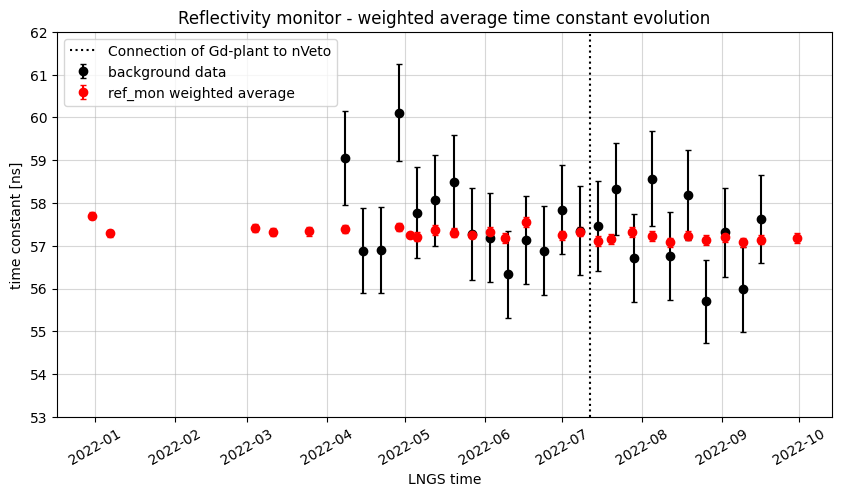

In [17]:

# plot the time constant evolution made from the weighted average of
# the taus of the ref_mon runs together with the background data

plt.figure(figsize=(10,5))

plt.errorbar(runs[:,1],taus,yerr=tau_errs,fmt='o',color='black',capsize=2,label='background data')
plt.errorbar(good_runs[0],av_means,yerr=av_mean_errs,fmt='o',color='red',capsize=2,label='ref_mon weighted average')
       
plt.title('Reflectivity monitor - weighted average time constant evolution')
plt.xlabel('LNGS time')
plt.ylabel('time constant [ns]')
plt.grid(alpha=0.5)
plt.ylim(53,62)
plt.gca().axvline(datetime.date(2022,7,12),linestyle=':',color='black',label='Connection of Gd-plant to nVeto')
plt.legend()
plt.xticks(rotation = 30)
plt.show()


In [15]:

# linear fit

def lin_fit(xx,yy,yy_errs,p0=[60,0.01],title='',fix_slope=False):
    
    
    # fitting function (linear function)

    def f(x,offset,slope):        
        return offset + slope*x
    
    fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(8,5),sharex=True,gridspec_kw={'height_ratios': [4, 1]})
    plt.subplots_adjust(left=0.1,bottom=0, right=0.9, top=0.9, wspace=0, hspace=0)    
    
    # x and y
    
    day_0 = datetime.date(2021,12,1)
    xx = np.array([ (xx[i] - day_0).days for i in range(len(xx)) ])
    ax[0].errorbar(xx,yy,yerr=yy_errs,fmt='o',color='black',capsize=2,label='data')

    
    # cost function
    
    least_squares = LeastSquares(xx,yy,yy_errs,f)
    
    
    # fit
    
    if fix_slope == False:
        m = Minuit(least_squares,offset=p0[0],slope=p0[1])
    else:
        m = Minuit(least_squares,offset=p0[0],slope=0)
        m.fixed['slope'] = True
    m.migrad()
    m.hesse()
    
    
    # compute the p-value

    p_value = 1 - stats.chi2.cdf(m.fval,df=len(xx)-m.nfit)
    
    
    # print the fit results
    
    print('Fit results:')
    print(f'offset = '+str(m.values[0])+' +/- '+str(m.errors[0])+' ns')
    if fix_slope == False:
        print(f'slope = '+str(m.values[1])+' +/- '+str(m.errors[1]))
    print(f'chi2 / dof = '+str(m.fval)+' / '+str(len(xx)-m.nfit))
    print(f'p-value = '+str(p_value))
    
    
    # plot and display the results
    
    xxx = np.linspace(xx[0],xx[-1],1000)
    yyy = f(xxx,m.values[0],m.values[1])
    ax[0].plot(xxx,yyy,color='red',label='fit')
    ax[0].set_title(title)
    ax[0].grid(alpha=0.3)
    plt.xlabel('days since 2021-12-01')
    ax[0].set_ylabel('time constant [ns]')
    
    fit_results = []
    fit_results.append(r'offset = ( '+str(round(m.values[0],2))+' $\pm$ '+str(round(m.errors[0],2))+' ) ns')
    if fix_slope == False:
        fit_results.append(r'slope = '+str(round(m.values[1]*1e3,2))+' $\pm$ '+str(round(m.errors[1]*1e3,2))+' $\cdot 10^{-3}$ ns / day')
    fit_results.append(r'$\chi^2$ / dof = '+str(round(m.fval,1))+' / '+str(len(xx)-m.nfit))
    fit_results.append(f'p-value = '+str(round(p_value,4)))
    ax[0].legend(title='\n'.join(fit_results))
                           
    
    # plot the residuals
    
    y_fit = f(xx,m.values[0],m.values[1])
    res = (yy - y_fit) / yy_errs
    # plt.figure(figsize=(6.1,1.5))
    ax[1].scatter(xx,res,s=3,c="black")
    ax[1].set_ylabel("pull")
    ax[1].axhline(0,linestyle="--",color="red",alpha=0.7)
    ax[1].axhline(-1,linestyle="--",color="green",alpha=0.5)
    ax[1].axhline(1,linestyle="--",color="green",alpha=0.5)
    ax[1].axhline(-2,linestyle="--",color="orange",alpha=0.5)
    ax[1].axhline(2,linestyle="--",color="orange",alpha=0.5)
    ax[1].axhline(-3,linestyle="--",color="blue",alpha=0.5)
    ax[1].axhline(3,linestyle="--",color="blue",alpha=0.5)
    plt.show()
                
    
    # reduced chi2
                           
    rcs = m.fval / (len(xx)-m.nfit)
           
                           
    # return tau, tau error, reduced chi2, noise rate, noise rate error
    
    return m.values[0],m.values[1],rcs,p_value
                 

In [48]:
len(used_runs)

39

In [49]:
len(av_means)

36

Fit results:
offset = 57.214625536896854 +/- 0.016141114990038924 ns
chi2 / dof = 71.53099746636458 / 39
p-value = 0.0011426482559315776


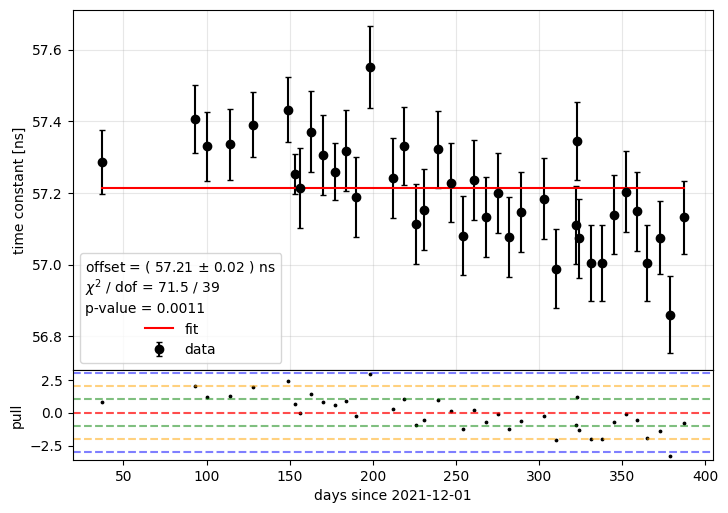

In [18]:

good_runs_2 = used_runs[1:]
good_runs_2 = list(good_runs_2[:28]) + list(good_runs_2[29:])
av_means_2 = weighted_averages[1:]
av_means_2 = list(av_means_2[:28]) + list(av_means_2[29:])
av_mean_errs_2 = w_av_errors[1:]
av_mean_errs_2 = list(av_mean_errs_2[:28]) + list(av_mean_errs_2[29:])

p0_mean, p1_mean, _, p = lin_fit(good_runs_2,av_means_2,av_mean_errs_2,p0=[60,0.01],title='',fix_slope=True)


In [31]:
len([good_runs_2[i][0] for i in range(len(good_runs_2))])

34

In [32]:
len(av_means_2)

34

In [35]:
good_runs[0][0]

array([datetime.date(2021, 12, 31), '037983'], dtype=object)

In [34]:
av_means[0]

57.703039589726195

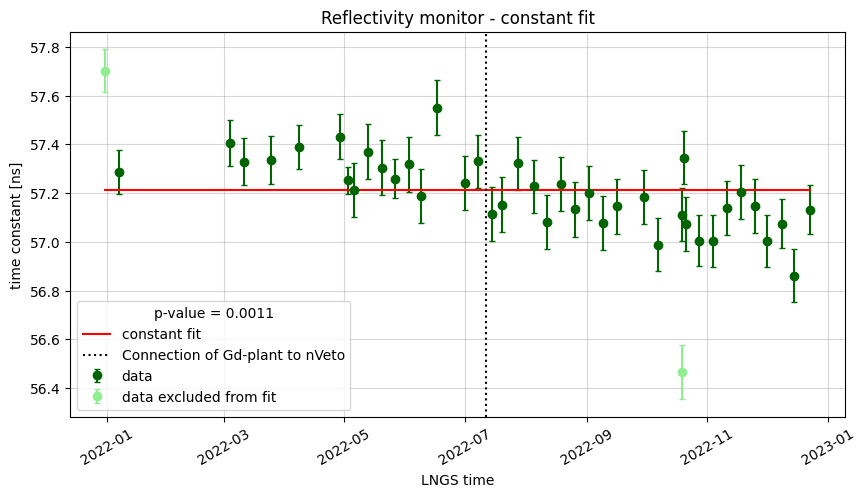

In [17]:

plt.figure(figsize=(10,5))

plt.errorbar(good_runs_2,av_means_2,yerr=av_mean_errs_2,fmt='o',color='darkgreen',capsize=2,label='data')
plt.errorbar(good_runs[0][0][0],av_means[0],yerr=av_mean_errs[0],fmt='o',color='lightgreen',capsize=2,label='data excluded from fit')
plt.errorbar(good_runs[0][29][0],av_means[29],yerr=av_mean_errs[29],fmt='o',color='lightgreen',capsize=2)
# plt.gca().axhline(p0_mean,color='red',label='constant fit')
plt.plot([good_runs[0][0][0],good_runs[0][-1][0]],[p0_mean,p0_mean],color='red',label='constant fit')

fit_result = ['p-value = '+str(round(p,4))]
       
plt.title('Reflectivity monitor - constant fit')
plt.xlabel('LNGS time')
plt.ylabel('time constant [ns]')
plt.grid(alpha=0.5)
plt.gca().axvline(datetime.date(2022,7,12),linestyle=':',color='black',label='Connection of Gd-plant to nVeto')
plt.legend(title='\n'.join(fit_result),loc='lower left')
plt.xticks(rotation = 30)

'''
plt.gca().axvspan(datetime.date(2021,12,15),datetime.date(2022,7,13),color='orange',alpha=0.2,label='WLP',zorder=1)
plt.gca().axvspan(datetime.date(2022,7,13),datetime.date(2022,7,29),color='lightblue',alpha=0.3,label='Gd-plant')
plt.gca().axvspan(datetime.date(2022,7,29),datetime.date(2022,8,4),color='orange',alpha=0.2)
plt.gca().axvspan(datetime.date(2022,8,4),datetime.date(2022,9,9),color='lightblue',alpha=0.3)
plt.gca().axvspan(datetime.date(2022,9,9),datetime.date(2022,10,27),color='orange',alpha=0.2)
plt.gca().axvspan(datetime.date(2022,10,27),datetime.date(2022,11,15),color='lightblue',alpha=0.2)
plt.gca().axvspan(datetime.date(2022,9,21),datetime.date(2022,10,17),color='red',alpha=0.1,label='operations above water tank',hatch='//')
plt.gca().margins(x=0)
'''

plt.show()


Fit results:
offset = 57.46015200304499 +/- 0.04330122435889515 ns
slope = -0.0010561792020111409 +/- 0.00017284347644369005
chi2 / dof = 34.188011096508205 / 38
p-value = 0.6463870599227137


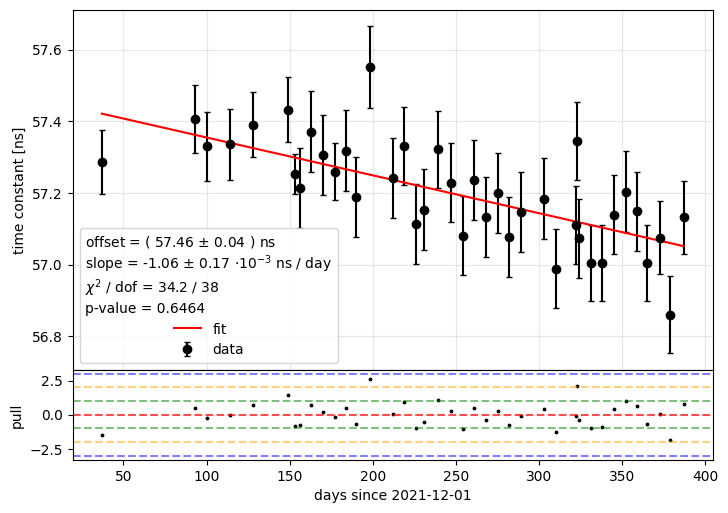

In [19]:

p0_mean_2, p1_mean_2, __2, p_2 = lin_fit(good_runs_2,av_means_2,av_mean_errs_2,p0=[60,0.01],title='',fix_slope=False)


In [20]:

y0 = (good_runs[0][0][0] - datetime.date(2021,12,1)).days * p1_mean_2 + p0_mean_2
y1 = (good_runs[0][-1][0] - datetime.date(2021,12,1)).days * p1_mean_2 + p0_mean_2


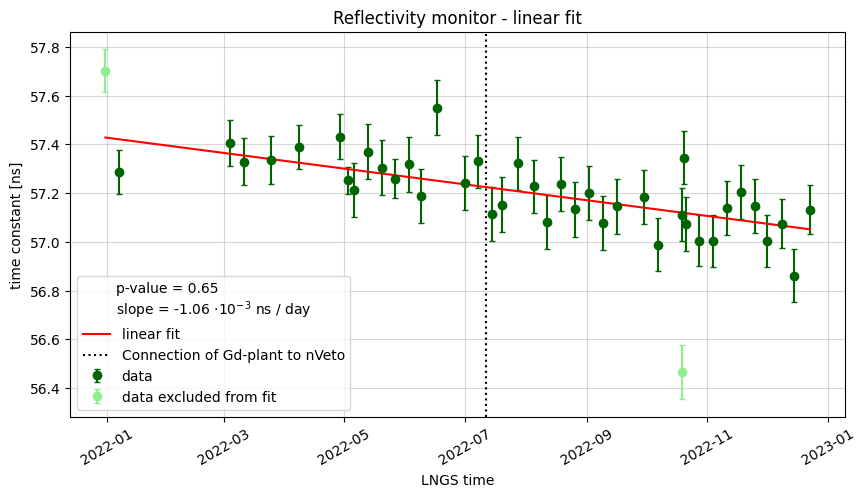

In [21]:

plt.figure(figsize=(10,5))

plt.errorbar(good_runs_2,av_means_2,yerr=av_mean_errs_2,fmt='o',color='darkgreen',capsize=2,label='data')
plt.errorbar(good_runs[0][0][0],av_means[0],yerr=av_mean_errs[0],fmt='o',color='lightgreen',capsize=2,label='data excluded from fit')
plt.errorbar(good_runs[0][29][0],av_means[29],yerr=av_mean_errs[29],fmt='o',color='lightgreen',capsize=2)
# plt.gca().axhline(p0_mean_2,color='red',label='constant fit')
plt.plot([good_runs[0][0][0],good_runs[0][-1][0]],[y0,y1],color='red',label='linear fit')

fit_result = ['p-value = '+str(round(p_2,2))]
fit_result.append(r'slope = '+str(round(p1_mean_2*1e3,2))+' $\cdot 10^{-3}$ ns / day')
       
plt.title('Reflectivity monitor - linear fit')
plt.xlabel('LNGS time')
plt.ylabel('time constant [ns]')
plt.grid(alpha=0.5)
plt.gca().axvline(datetime.date(2022,7,12),linestyle=':',color='black',label='Connection of Gd-plant to nVeto')
plt.legend(title='\n'.join(fit_result),loc='lower left')
plt.xticks(rotation = 30)
plt.show()


TypeError: unsupported operand type(s) for -: 'str' and 'datetime.date'

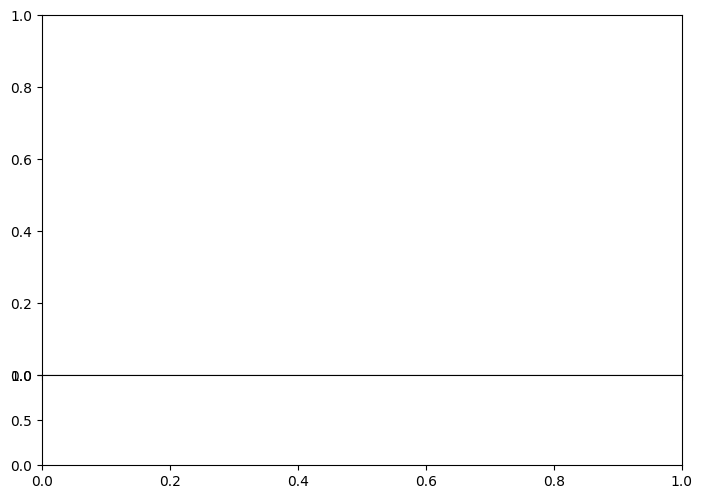

In [22]:

lin_fit(runs[:,1],taus_ref_mon,tau_errs_ref_mon,p0=[60,0.01],title='',fix_slope=True)


In [23]:

lin_fit(runs[:,1],taus,tau_errs,p0=[60,0.01],title='',fix_slope=False)


NameError: name 'taus' is not defined

In [24]:

# linear fit

def lin_fit_2(xx,yy,yy_errs,p0=[60,0.01],title='',fix_slope=False):
    
    
    # fitting function (linear function)

    def f(x,offset,slope):        
        return offset + slope*x
    
    fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(8,5),sharex=True,gridspec_kw={'height_ratios': [4, 1]})
    plt.subplots_adjust(left=0.1,bottom=0, right=0.9, top=0.9, wspace=0, hspace=0)    
    
    # x and y
    
    day_0 = datetime.date(2021,12,1)
    xx = np.array([ (xx[i] - day_0).days for i in range(len(xx)) ])
    ax[0].errorbar(xx,yy,yerr=yy_errs,fmt='o',color='black',capsize=2,label='data')

    
    # cost function
    
    least_squares = LeastSquares(xx,yy,yy_errs,f)
    
    
    # fit
    
    if fix_slope == False:
        m = Minuit(least_squares,offset=p0[0],slope=p0[1])
    else:
        m = Minuit(least_squares,offset=p0[0],slope=0)
        m.fixed['slope'] = True
    m.migrad()
    m.hesse()
    
    
    # compute the p-value

    p_value = 1 - stats.chi2.cdf(m.fval,df=len(xx)-m.nfit)
    
    
    # print the fit results
    
    print('Fit results:')
    print(f'offset = '+str(m.values[0])+' +/- '+str(m.errors[0])+' ns')
    if fix_slope == False:
        print(f'slope = '+str(m.values[1])+' +/- '+str(m.errors[1]))
    print(f'chi2 / dof = '+str(m.fval)+' / '+str(len(xx)-m.nfit))
    print(f'p-value = '+str(p_value))
    
    
    # plot and display the results
    
    xxx = np.linspace(xx[0],xx[-1],1000)
    yyy = f(xxx,m.values[0],m.values[1])
    ax[0].plot(xxx,yyy,color='red',label='fit')
    ax[0].set_title(title)
    ax[0].grid(alpha=0.3)
    plt.xlabel('days since 2021-12-01')
    ax[0].set_ylabel('time constant [ns]')
    
    fit_results = []
    fit_results.append(r'offset = ( '+str(round(m.values[0],2))+' $\pm$ '+str(round(m.errors[0],2))+' ) ns')
    if fix_slope == False:
        fit_results.append(r'slope = '+str(round(m.values[1]*1e3,2))+' $\pm$ '+str(round(m.errors[1]*1e3,2))+' $\cdot 10^{-3}$ ns / day')
    fit_results.append(r'$\chi^2$ / dof = '+str(round(m.fval,1))+' / '+str(len(xx)-m.nfit))
    fit_results.append(f'p-value = {p_value:.2f}')
    ax[0].legend(title='\n'.join(fit_results))
                           
    
    # plot the residuals
    
    y_fit = f(xx,m.values[0],m.values[1])
    res = (yy - y_fit) / yy_errs
    # plt.figure(figsize=(6.1,1.5))
    ax[1].scatter(xx,res,s=3,c="black")
    ax[1].set_ylabel("pull")
    ax[1].axhline(0,linestyle="--",color="red",alpha=0.7)
    ax[1].axhline(-1,linestyle="--",color="green",alpha=0.5)
    ax[1].axhline(1,linestyle="--",color="green",alpha=0.5)
    ax[1].axhline(-2,linestyle="--",color="orange",alpha=0.5)
    ax[1].axhline(2,linestyle="--",color="orange",alpha=0.5)
    ax[1].axhline(-3,linestyle="--",color="blue",alpha=0.5)
    ax[1].axhline(3,linestyle="--",color="blue",alpha=0.5)
    plt.show()
                
    
    # reduced chi2
                           
    rcs = m.fval / (len(xx)-m.nfit)
           
                           
    # return tau, tau error, reduced chi2, noise rate, noise rate error
    
    return m.values[0],m.errors[0],rcs,p_value
                 

Fit results:
offset = 57.30816943364024 +/- 0.022909642144275627 ns
chi2 / dof = 15.572417015054395 / 16
p-value = 0.4831798581348302


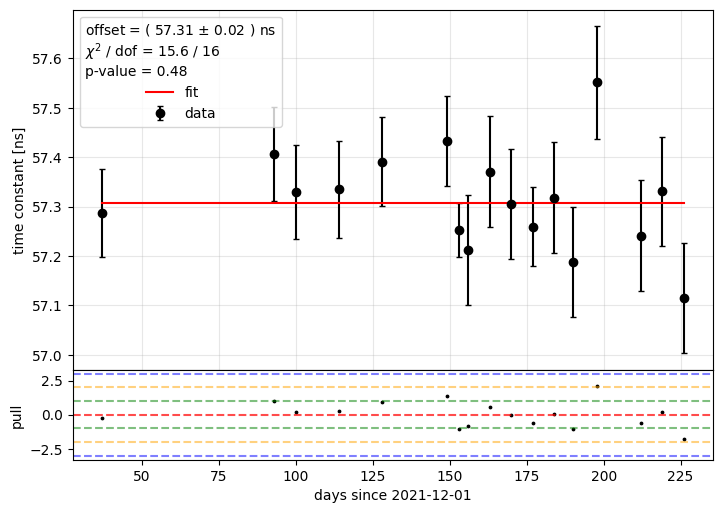

In [25]:

p0_mean_3, p0_error_3, pogba, p_3 = lin_fit_2(good_runs_2[:17],av_means_2[:17],av_mean_errs_2[:17],p0=[60,0.01],title='',fix_slope=True)


Fit results:
offset = 57.12241959822328 +/- 0.02274521372858614 ns
chi2 / dof = 22.85253640529575 / 22
p-value = 0.4100961091475339


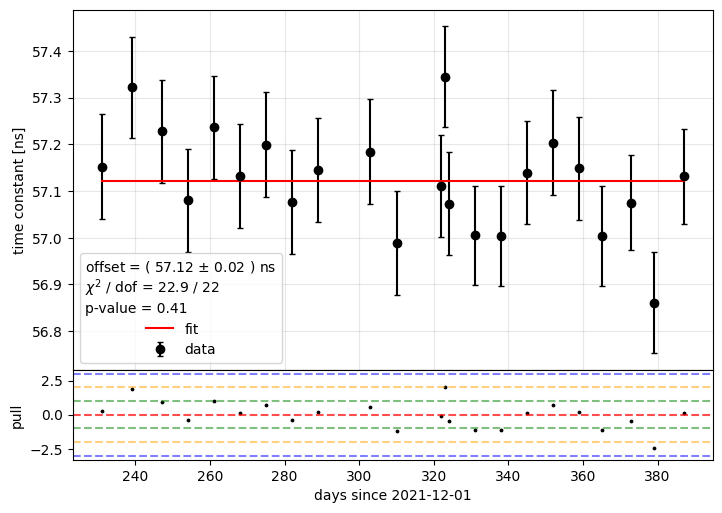

In [26]:

p0_mean_4, p0_error_4, danilo, p_4 = lin_fit_2(good_runs_2[17:],av_means_2[17:],av_mean_errs_2[17:],p0=[60,0.01],title='',fix_slope=True)


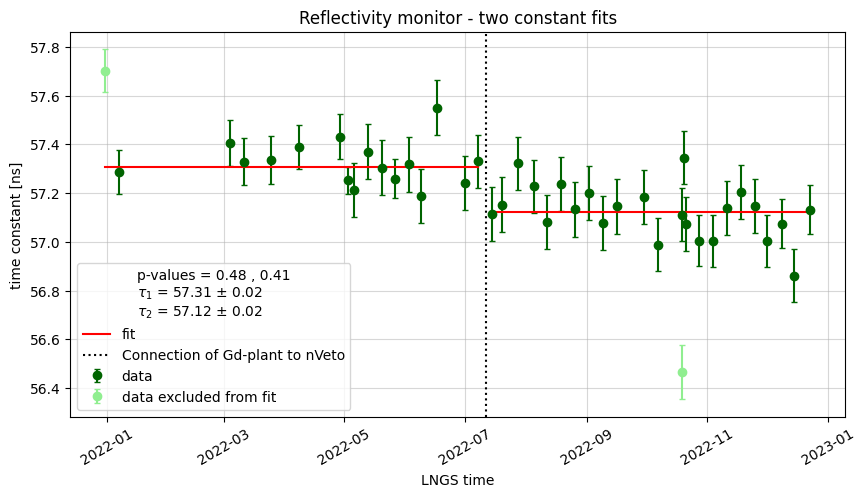

In [27]:

plt.figure(figsize=(10,5))

plt.errorbar(good_runs_2,av_means_2,yerr=av_mean_errs_2,fmt='o',color='darkgreen',capsize=2,label='data')
plt.errorbar(good_runs[0][0][0],av_means[0],yerr=av_mean_errs[0],fmt='o',color='lightgreen',capsize=2,label='data excluded from fit')
plt.errorbar(good_runs[0][29][0],av_means[29],yerr=av_mean_errs[29],fmt='o',color='lightgreen',capsize=2)
plt.plot([good_runs[0][0][0],good_runs[0][15][0]],[p0_mean_3,p0_mean_3],color='red',label='fit')
plt.plot([good_runs[0][16][0],good_runs[0][-1][0]],[p0_mean_4,p0_mean_4],color='red')


fit_result = ['p-values = '+str(round(p_3,2))+' , '+str(round(p_4,2))]
fit_result.append(r'$\tau_1$ = '+str(round(p0_mean_3,2))+' $\pm$ '+str(round(p0_error_3,2)))
fit_result.append(r'$\tau_2$ = '+str(round(p0_mean_4,2))+' $\pm$ '+str(round(p0_error_4,2)))
       
plt.title('Reflectivity monitor - two constant fits')
plt.xlabel('LNGS time')
plt.ylabel('time constant [ns]')
plt.grid(alpha=0.5)
plt.gca().axvline(datetime.date(2022,7,12),linestyle=':',color='black',label='Connection of Gd-plant to nVeto')
plt.legend(title='\n'.join(fit_result),loc='lower left')
plt.xticks(rotation = 30)
plt.show()
